<center><img src="https://pure.ups.edu.ec/skin/headerImage/" width="300" height="300"></center>

<h1><center>Universidad Politecnica Salesiana</center></h1>
<h2><center>Simulacion Vacunacion con Interrupciones</center></h2>


<b>Nombre: </b> Javier Vazquez

<b>Materia: </b> Simulacion


## Simpy Interrupciones

En base a la práctica del COVID vacunación, realizar el proceso de interrupción en base a que el 5% de los pacientes que estan en la sala de espera presentan complicaciones de salud y deben ser trasladados inmediatamente al centro de salud más cercano y ser atendidos. Realizar este proceso y generar una segunda linea de simulación para el traslado, atención y alta del paciente que presenta complicaciones en base a los siguientes datos:
    
- Traslado de la ambulancia 5 - 15 minutos.
- Atención en el centro de salud 5 - 24 horas.
- Alta 1 - 2 horas.
- El 10% de las personas presentan que presentaron complicaciones fallecen.

Generar gráficas que indiquen las personas que presentaron complicaciones en base a los tiempos, estado de las personas y respuesta.

In [9]:
import simpy 
import random 
import numpy as np

### Variables de Interes 
* <b> Tiempo Post Vacuna: </b> tiempo de espera obligatoria para las personas que son vacunadas
* <b> Mesas: </b> numero de mesas de vacunacion con las que cuenta el recinto
* <b> Control signos: </b> tiempo en tomar el control de signos vitales, tiempo minimo 
* <b> Tiempo Simulacion: </b> este tiempo esta dado por el numero de semanas, trabajando 3 jornadas de vacunacion con 9 horas diarias de trabajo 
* <b> Tiempo de vacunacion: </b> tiempo demora en aplicar la vacuna, tiempo minumo

In [10]:
TIEMPO_POST_VACUNA = 20
MESAS = 10

CONTROL_SIGNOS = 1
SEMANAS = 2
TIEMPO_VACUNACION = 5
TIEMPO_SIMULACION = SEMANAS * 3 * 9 * 60 # Tiempo simulacion 3 dias a la semana 9 horias diarias 



### Variables Auxiliares

In [11]:
cont={0:1}
personas_complicaciones=[]
personas_muertas=[]
personas_altas=[]
personas_total=[]
tiempo_vacunacion={}

### Desarrollo 

Se define la clase Vacunacion la cual tendra todos los procesos por la cual tiene que pasar la persona
1. La persona llega al recinto y se toma el control de los signos vitales, para poder continuar con el proceso
2. Si la persona paso el primer control, se le asigna una mesa de vacunacion, en donde se demora entre 5 y 10 minutos en aplicar la vacuna.
3. Despues pasa a una sala de espera donde se verifica que no existan complicaciones
4. Un porcesos paralelo esta verificando cada cierto tiempo si no existen complicaciones en los pacientes, de serlo asi, se toma al paciente y se traslada en ambulancia a un centro de salud, este traslado tarde entre 5 y 15 minutos. Posteriormente se le atiende en un tiempo de 5 a 24 horas. 
5. En el centro de salud, un 10% de las personas fallecen, si no se da el caso al paciente se da el alta en un tiempo de 1 a 2 horas

In [12]:
class Vacunacion():
    def __init__(self, env, nombre, recinto):
        self.env = env
        self.nombre = nombre
        self.complicacion = False
        self.control = False
        self.personas_vacunadas = 0
        self.personas = 0
        self.proceso = env.process(self.proceso_vacunar(recinto))
        env.process(self.complicacion_persona())
        
    def control_signos(self):
        yield self.env.timeout(random.randint(CONTROL_SIGNOS, CONTROL_SIGNOS+2))
    
    def logs_procesos(self,icon,nombre, accion, hora):
        print(" %s nombre: [%s] accion:  [%s] hora:  [%d] "%(icon,nombre, accion, hora))
    
    def aplicar_vacuna(self):
        yield self.env.timeout(random.randint(TIEMPO_VACUNACION, TIEMPO_VACUNACION+5))
        
    def post_vacuna(self, tiempo):
        yield self.env.timeout(tiempo)
        
    
    def proceso_vacunar(self, recinto):
        while True:
            try:
                nombre= 'persona '+str(cont[0])
                cont[0]=cont[0]+1
                personas_total.append(nombre)
                self.logs_procesos("--->",nombre," llega al recinto",self.env.now)
                yield env.process(self.control_signos())
                if random.randint(1,100) > 10:
                    self.logs_procesos("🛂", nombre, "pasa el control", env.now)
                    inicio_vacunacion =  self.env.now
                    yield env.process(self.aplicar_vacuna())
                    tiempo_vacunacion[nombre] = self.env.now - inicio_vacunacion
                    self.logs_procesos("💉", nombre, "fue vacunada ", self.env.now)
                
                    tiempo_post_vacuna = TIEMPO_POST_VACUNA
                    inicio = self.env.now
                    self.control = True
                    yield env.process(self.post_vacuna(tiempo_post_vacuna))
                    tiempo_post_vacuna = 0
                    self.logs_procesos("✅", nombre, "sin complicaciones", self.env.now)
                    self.personas_vacunadas += 1
                else:
                    self.logs_procesos("❌", nombre,"no pasa el control", self.env.now)
            except simpy.Interrupt:
                self.complicacion = True
                self.logs_procesos("⚠️", nombre,"presenta complicaciones", self.env.now)
                tiempo_post_vacuna -= self.env.now - inicio
                personas_complicaciones.append(nombre)
                with recinto.request(priority=1) as requerimiento:
                    yield requerimiento
                    env.process(self.proceso_traslado(nombre))
                        
                self.complicacion = False
    
    def complicacion_persona(self):
        while True:
            yield self.env.timeout(25)
            if random.randint(1,100) <=5:
                if not self.complicacion:
                    self.proceso.interrupt()
    
    def proceso_traslado(self, nombre):
        self.logs_procesos('🚑 ', nombre,' se trasladada en ambulancia ',self.env.now)
        
        yield self.env.timeout(random.randint(5,15)) # tiempo traslado en ambulancia 
        self.logs_procesos('👨‍⚕️', nombre,' es atendido', self.env.now)
        yield self.env.timeout(random.randint(300,1200)) # tiempo en ser atendido 5-24 horas 
        
        if random.randint(1,100) <=10:
            self.logs_procesos('☠️',nombre,' ha fallecido', self.env.now)
            personas_muertas.append(nombre)
        else:
            yield self.env.timeout(random.randint(60,120)) # tiempo en dar alta 1-2 horas
            self.logs_procesos('<---', nombre,'recibe el alta', self.env.now)
            personas_altas.append(nombre)
        

### Ejecutar Simulacion 


In [13]:
env = simpy.Environment()
recinto = simpy.PreemptiveResource(env, capacity=1)
vacunacion = [Vacunacion(env,"Mesa %d"% i, recinto) for i in range(MESAS)]
env.run(until=TIEMPO_SIMULACION)
print("Simulacion realizada despues de %d semanas"%SEMANAS)
for i in vacunacion:
    print("[%s] ha vacunado a [%d] personas"%(i.nombre,i.personas_vacunadas))

 ---> nombre: [persona 1] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 2] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 3] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 4] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 5] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 6] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 7] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 8] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 9] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 10] accion:  [ llega al recinto] hora:  [0] 
 🛂 nombre: [persona 2] accion:  [pasa el control] hora:  [1] 
 🛂 nombre: [persona 5] accion:  [pasa el control] hora:  [1] 
 🛂 nombre: [persona 1] accion:  [pasa el control] hora:  [2] 
 🛂 nombre: [persona 4] accion:  [pasa el control] hora:  [2] 
 🛂 nombre: [persona 6] accion:  [pasa el control] hora:  [2] 
 🛂 nombre: [persona

 💉 nombre: [persona 430] accion:  [fue vacunada ] hora:  [1107] 
 💉 nombre: [persona 428] accion:  [fue vacunada ] hora:  [1108] 
 👨‍⚕️ nombre: [persona 420] accion:  [ es atendido] hora:  [1110] 
 ✅ nombre: [persona 417] accion:  [sin complicaciones] hora:  [1111] 
 ---> nombre: [persona 431] accion:  [ llega al recinto] hora:  [1111] 
 🛂 nombre: [persona 431] accion:  [pasa el control] hora:  [1112] 
 ✅ nombre: [persona 419] accion:  [sin complicaciones] hora:  [1113] 
 ---> nombre: [persona 432] accion:  [ llega al recinto] hora:  [1113] 
 ✅ nombre: [persona 421] accion:  [sin complicaciones] hora:  [1114] 
 ---> nombre: [persona 433] accion:  [ llega al recinto] hora:  [1114] 
 ✅ nombre: [persona 425] accion:  [sin complicaciones] hora:  [1116] 
 ---> nombre: [persona 434] accion:  [ llega al recinto] hora:  [1116] 
 🛂 nombre: [persona 432] accion:  [pasa el control] hora:  [1116] 
 ✅ nombre: [persona 424] accion:  [sin complicaciones] hora:  [1117] 
 ---> nombre: [persona 435] acc

 <--- nombre: [persona 512] accion:  [recibe el alta] hora:  [2120] 
 💉 nombre: [persona 817] accion:  [fue vacunada ] hora:  [2120] 
 🛂 nombre: [persona 818] accion:  [pasa el control] hora:  [2121] 
 🛂 nombre: [persona 819] accion:  [pasa el control] hora:  [2122] 
 ✅ nombre: [persona 810] accion:  [sin complicaciones] hora:  [2124] 
 ---> nombre: [persona 820] accion:  [ llega al recinto] hora:  [2124] 
 ✅ nombre: [persona 811] accion:  [sin complicaciones] hora:  [2124] 
 ---> nombre: [persona 821] accion:  [ llega al recinto] hora:  [2124] 
 ⚠️ nombre: [persona 818] accion:  [presenta complicaciones] hora:  [2125] 
 ---> nombre: [persona 822] accion:  [ llega al recinto] hora:  [2125] 
 🚑  nombre: [persona 818] accion:  [ se trasladada en ambulancia ] hora:  [2125] 
 🛂 nombre: [persona 821] accion:  [pasa el control] hora:  [2126] 
 🛂 nombre: [persona 820] accion:  [pasa el control] hora:  [2127] 
 💉 nombre: [persona 819] accion:  [fue vacunada ] hora:  [2128] 
 🛂 nombre: [persona

## Resultados 

In [14]:
print('-'*70,'\n Total de personas: ', len(personas_total))
print('Personas que presentan complicaciones: ', len(personas_complicaciones))
print('Personas que murieron: ', len(personas_muertas))
print('Personas que fueron dadas de alta: ',len(personas_altas))

---------------------------------------------------------------------- 
 Total de personas:  1254
Personas que presentan complicaciones:  64
Personas que murieron:  5
Personas que fueron dadas de alta:  41


### Grafica de Complicaciones

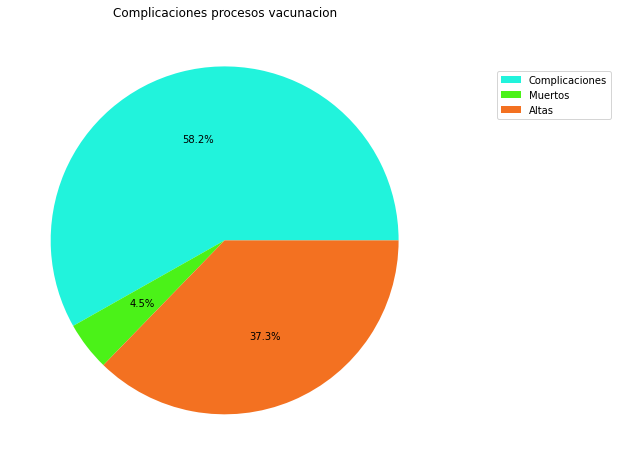

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.pie([len(personas_complicaciones), len(personas_muertas), len(personas_altas)],colors=['#21F3DC','#4BF218','#F37121'],autopct='%1.1f%%')
plt.legend(['Complicaciones','Muertos','Altas'],bbox_to_anchor=(0.9, 0, 0.5, 0.9))
plt.title('Complicaciones procesos vacunacion')
plt.show()

### Tiempo vacunacion personas

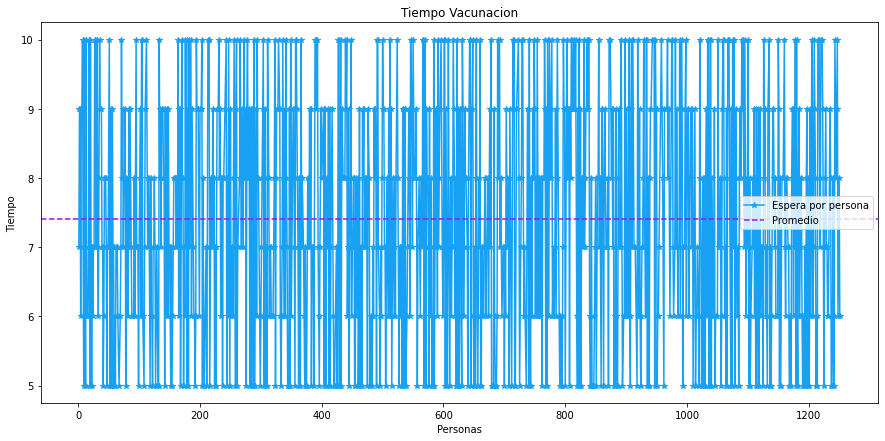

In [16]:
promedio_vacunacion={}
for i in list(tiempo_vacunacion.keys()):
    #print(i.split('-'))
    promedio_vacunacion[int(i.split(' ')[1])]=tiempo_vacunacion[i]

    promedio_vacunacion=dict(sorted(promedio_vacunacion.items()))  
plt.figure(figsize = (15,7))
plt.plot(promedio_vacunacion.keys(), promedio_vacunacion.values(),'*-', color='#18A1F2')
plt.axhline(y=sum(list(tiempo_vacunacion.values()))/len(tiempo_vacunacion), xmin=0.0, xmax=1,color='#9318F2',linestyle="--")
plt.title('Tiempo Vacunacion')
plt.xlabel('Personas')
plt.ylabel('Tiempo')
plt.legend(['Espera por persona', 'Promedio'])
plt.show()

### Conclusiones 

Gracias a las interrupciones nos permiten detener el proceso principal que se esta desarrollando dando prioridad a la actividad que surgio y la que activo la interrupcion, los cuales paralelamente se estan desarrollando, mientras el proceso uno se interrumpe el segundo sigue con sus actividades